# Introduction

- I have taken Record History Data from F1 archives (<a href='https://ergast.com/mrd/'>Ergast API</a>) to perform various Clustering Algorithms.
- The Data is cleaned in the previous sections.
- Overview of Data Cleaning:
    - F1 archives have important information about races held since 1950 to the current season.
    - There are different tables of data that can be extracted such as Results of the Race, Constructor (Team) Information, Driver Information, Results of the Qualification, Season-End Results and many more.
    - These individual tables have data inside dictionaries inside every row.
    - These dictionaries can be expanded and every dictionary can be transformed into a separate table.
    - Valuable information from these tables are then concatenated/joined into one master table
- The master table has consists of 26,941 rows and 21 feature variables and 1 label column.
- Some of the feature variables include laps in the race, grid position held, age at time of the race, history of wins in the past, history of laps completed in the past, weather of the race, points gained in the race and many more.
- The label column is based on the position achieved by a single driver in a particular race. The position range from 1 to 20/21/22 (based on the number of drivers that races in that particular race). For simplification purposes, the positions have been grouped into 3 different sections:
    - Podium (Top 3 finish)
    - Top_10 (Positions 4-10)
    - Outside Top_10 (Positions 10 and above)
- The motivation behind these sections were solely based on the fact that Top 3 finish receive more points than Positions 4-10, while Positions 10 and above do not receive any points at all.
- From the clustering analysis, I want to see that without the label column (Un-supervised ML), do we still achieve the same number of clusters as the sections that were originally decided upon i.e., 3.

# Import Libraries

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette='Set2')

from scipy.spatial.distance import cdist
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle
from sklearn.cluster import Birch
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')
import time


# Import Data

In [162]:
df = pd.read_csv('../../data/02-model-data/data_cleaned.csv')
df.head()

season  round season_round  driverId  raceId  circuitId  position  points  \
0    1950      1       1950_1       642     833          9         1     9.0   
1    1950      1       1950_1       786     833          9         2     6.0   
2    1950      1       1950_1       686     833          9         3     4.0   
3    1950      1       1950_1       704     833          9         4     3.0   
4    1950      1       1950_1       627     833          9         5     2.0   

   grid  laps  ... weather           stop age_on_race cumulative_points  \
0     1    70  ...    Fine  Not Available          44               9.0   
1     2    70  ...    Fine  Not Available          52               6.0   
2     4    70  ...    Fine  Not Available          39               4.0   
3     6    68  ...    Fine  Not Available          46               3.0   
4     9    68  ...    Fine  Not Available          45               2.0   

   cumulative_laps  pole_driverId  pole_history  win_driverId  win_history  \
0               70            642             1           642            1   
1               70            642             0           642            0   
2               70            642             0           642            0   
3               68            642             0           642            0   
4               68            642             0           642            0   

    label  
0  Podium  
1  Podium  
2  Podium  
3  Top_10  
4  Top_10  

[5 rows x 22 columns]

In [163]:
df.shape

(26941, 22)

# Data Pre-Processing and Visualization

- The cleaned data needs some pre-processing for it to be fed into Clustering models.
- Overview of `Pre-Processing`:
    - Dropping unnecessary columns.
    - The current season should not be taken into consideration while performing any Machine Learning algorithms since it is still ongoing.
    - All the features should be numeric.
        - The features that are already numeric should be normalized.
        - Some of the numeric features such as 'season', 'round' are categories and should be converted to categorical data type.
        - Variables such as 'status', 'weather' and 'stop' are not numerical and should be One-Hot Encoded to numeric.
    - Lastly, the label column is not needed to perform Clustering Algorithms, hence it should be dropped before running Clustering Algorithms.

In [164]:
df.drop(['season_round', 'constructorRef', 'raceId'], axis=1, inplace=True)

In [165]:
df = df[df['season'] != 2022]

In [166]:
df.columns

Index(['season', 'round', 'driverId', 'circuitId', 'position', 'points',
       'grid', 'laps', 'status', 'weather', 'stop', 'age_on_race',
       'cumulative_points', 'cumulative_laps', 'pole_driverId', 'pole_history',
       'win_driverId', 'win_history', 'label'],
      dtype='object')

In [167]:
numeric_features = ['season', 'driverId' , 'round' , 'circuitId' , 'pole_driverId' , 'position' ,'points', 'grid',
                    'laps', 'age_on_race', 'cumulative_points', 'cumulative_laps', 'pole_history', 'win_history', 'win_driverId']

categorical_features = ['status', 'weather', 'stop']

In [168]:
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [169]:
df['season'] = df['season'].astype('category')
df['driverId'] = df['driverId'].astype('category')
df['round'] = df['round'].astype('category')
df['circuitId'] = df['circuitId'].astype('category')
df['pole_driverId'] = df['pole_driverId'].astype('category')
df['win_driverId'] = df['win_driverId'].astype('category')
df['position'] = df['position'].astype('category')
df['grid'] = df['grid'].astype('category')

In [170]:
df = pd.get_dummies(df, columns=categorical_features)

In [171]:
df.head()

season     round  driverId circuitId  position    points      grid  \
0 -1.910324 -1.468876  1.413545 -0.803986 -1.532137  1.803095 -1.400046   
1 -1.910324 -1.468876  1.957913 -0.803986 -1.402770  1.053931 -1.262381   
2 -1.910324 -1.468876  1.579880 -0.803986 -1.273404  0.554488 -0.987052   
3 -1.910324 -1.468876  1.647926 -0.803986 -1.144037  0.304767 -0.711723   
4 -1.910324 -1.468876  1.356840 -0.803986 -1.014670  0.055046 -0.298729   

       laps  age_on_race  cumulative_points  ...  weather_Snowy weather_Sunny  \
0  0.794341     2.483855          -0.385949  ...              0             0   
1  0.794341     3.928107          -0.393713  ...              0             0   
2  0.794341     1.581198          -0.398889  ...              0             0   
3  0.728096     2.844918          -0.401477  ...              0             0   
4  0.728096     2.664387          -0.404065  ...              0             0   

   weather_Windy stop_Five  stop_Four stop_Not Available  stop_One  stop_Six  \
0              0         0          0                  1         0         0   
1              0         0          0                  1         0         0   
2              0         0          0                  1         0         0   
3              0         0          0                  1         0         0   
4              0         0          0                  1         0         0   

   stop_Three  stop_Two  
0           0         0  
1           0         0  
2           0         0  
3           0         0  
4           0         0  

[5 rows x 34 columns]

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26621 entries, 0 to 26620
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   season                   26621 non-null  category
 1   round                    26621 non-null  category
 2   driverId                 26621 non-null  category
 3   circuitId                26621 non-null  category
 4   position                 26621 non-null  category
 5   points                   26621 non-null  float64 
 6   grid                     26621 non-null  category
 7   laps                     26621 non-null  float64 
 8   age_on_race              26621 non-null  float64 
 9   cumulative_points        26621 non-null  float64 
 10  cumulative_laps          26621 non-null  float64 
 11  pole_driverId            26621 non-null  category
 12  pole_history             26621 non-null  float64 
 13  win_driverId             26621 non-null  category
 14  win_hi

In [173]:
df.describe()

points          laps   age_on_race  cumulative_points  \
count  2.662100e+04  2.662100e+04  2.662100e+04       2.662100e+04   
mean   8.869780e-14  1.418972e-15 -1.343136e-15      -3.520447e-16   
std    1.000019e+00  1.000019e+00  1.000019e+00       1.000019e+00   
min   -4.443970e-01 -1.524228e+00 -2.209962e+00      -4.092412e-01   
25%   -4.443970e-01 -8.286577e-01 -7.657108e-01      -4.040651e-01   
50%   -4.443970e-01  1.981373e-01 -4.358498e-02      -3.523044e-01   
75%    5.504573e-02  6.949735e-01  6.785409e-01      -5.209218e-02   
max    1.204167e+01  5.100255e+00  5.191827e+00       1.036605e+01   

       cumulative_laps  pole_history   win_history  status_Accident  \
count     2.662100e+04  2.662100e+04  2.662100e+04     26621.000000   
mean     -1.600204e-15  2.277195e-14 -2.390364e-14         0.041959   
std       1.000019e+00  1.000019e+00  1.000019e+00         0.200500   
min      -8.824187e-01 -3.807719e-01 -3.728114e-01         0.000000   
25%      -7.258831e-01 -3.807719e-01 -3.728114e-01         0.000000   
50%      -3.662826e-01 -3.807719e-01 -3.728114e-01         0.000000   
75%       3.797267e-01 -1.838849e-01 -1.842184e-01         0.000000   
max       4.854550e+00  9.758907e+00  9.339728e+00         1.000000   

       status_Finished  status_Lapped  ...  weather_Snowy  weather_Sunny  \
count     26621.000000   26621.000000  ...   26621.000000   26621.000000   
mean          0.261523       0.284925  ...       0.005973       0.459825   
std           0.439472       0.451387  ...       0.077054       0.498393   
min           0.000000       0.000000  ...       0.000000       0.000000   
25%           0.000000       0.000000  ...       0.000000       0.000000   
50%           0.000000       0.000000  ...       0.000000       0.000000   
75%           1.000000       1.000000  ...       0.000000       1.000000   
max           1.000000       1.000000  ...       1.000000       1.000000   

       weather_Windy     stop_Five     stop_Four  stop_Not Available  \
count   26621.000000  26621.000000  26621.000000        26621.000000   
mean        0.093648      0.002930      0.009128            0.838811   
std         0.291344      0.054051      0.095106            0.367712   
min         0.000000      0.000000      0.000000            0.000000   
25%         0.000000      0.000000      0.000000            1.000000   
50%         0.000000      0.000000      0.000000            1.000000   
75%         0.000000      0.000000      0.000000            1.000000   
max         1.000000      1.000000      1.000000            1.000000   

           stop_One      stop_Six    stop_Three      stop_Two  
count  26621.000000  26621.000000  26621.000000  26621.000000  
mean       0.053003      0.000676      0.032531      0.062920  
std        0.224044      0.025995      0.177408      0.242824  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000  

[8 rows x 25 columns]

In [174]:
X = df.drop(['label'], axis=1)
y = df['label']

# Clustering

- Clustering is a Machine Learning method that groups vectors or observations (set of objects) into groups (clusters).
- If we are given a set of vectors, each data point or vector can be classified into a particular group.
- Suppose there are n amount of vectors in 1 cluster and there are m amount of clusters for a specific data. In theory, the n vectors in each cluster are similar to each other and have the same properties and the vectors that are not in the same cluster should have different properties.
- Clustering is an Un-supervised ML method which means that there is no target variable present while creating a clustering model.
- When no predefined classification is required but the data needs to be organized into logical groupings, clustering techniques are applied.
- By examining the groups that our data points fall into after using a clustering algorithm, we can utilize it to gain some valuable insights about our data.
- Some of the applications of Clustering include:
    - Market segmentation
    - Social network analysis
    - Grouping of search results
    - Medical image processing
    - Image segmentation
    - Anomaly detection.
- The grouping of data into clusters is based on spatial similarity of different vectors. The spatial separation between the vectors, is referred to as similarity. There are several ways to calculate this distance. But this fact already shows that there isn't a standard, well-defined process for cluster determination. Hence, there are different Algorithms to group the data into clusters:
    - Connectivity Models: Hierarchical Clustering (Agglomerative and Birch Clustering)
    - Centroid Models: K-Means Clustering
    - Density Models: DBSCAN and OPTICS Clustering
    - Distribution Models
    - Subspace Models
    - Graph-based Models
    - Group Models
    - Neural Models and so on.
- As always, there are some drawbacks with Clustering:
    - With very large data sets, the key concept of clustering – the distance between individual measurements / observations – is made useless by the so-called curse of dimensionality. This makes it very time consuming for large datasets – especially if the space has multiple dimensions.
    - Shortcomings of existing (and applied) algorithms. These include:
        - the inability to recognise whether the data set is homogeneous or contains clusters.
        - the inability to rank variables according to their contribution to the heterogeneity of the dataset.
        - the inability to recognise specific patterns: Cluster centers, core regions, boundaries of clusters, zones of mixing, noise or even outliers.
        - the inability to estimate the correct number of clusters.
        - Moreover, each algorithm is designed to find the same type of clusters. As a result, it fails as soon as there is a mixture of clusters with different properties.
    - The effectiveness of the clustering is determined by the chosen method of distance measurement. Usually, there is no universally correct result. This is due to the fact that it varies drastically depending on the different methods, each with different parameters.

## Clustering with random Hyper-parameters

For every algorithm that performs Clustering on a dataset, there are many hyperparameters that needs to be specified beforehand. But these hyper-parameters need to be tuned, keeping in mind our dataset. Giving random hyperparameters that do not match our dataset may result in loss of data and/or wrong datapoints being classified into clusters. Thus before hyper-parameter tuning, let's see a k-means model with random hyperparameters as follows:
- Initializer: kmeans++
- Number of clusters: 6
- Maximum iterations: 300
- Random state: 1973

In [175]:
kmeans = KMeans(
    init="k-means++",
    n_clusters=6,
    max_iter=300,
    random_state=1973)

label = kmeans.fit_predict(X)

In [176]:
df['cluster_label'] = label

In [177]:
df.columns

Index(['season', 'round', 'driverId', 'circuitId', 'position', 'points',
       'grid', 'laps', 'age_on_race', 'cumulative_points', 'cumulative_laps',
       'pole_driverId', 'pole_history', 'win_driverId', 'win_history', 'label',
       'status_Accident', 'status_Finished', 'status_Lapped',
       'status_Mechanical_Issue', 'weather_Cloudy', 'weather_Fine',
       'weather_Not Available', 'weather_Rainy', 'weather_Snowy',
       'weather_Sunny', 'weather_Windy', 'stop_Five', 'stop_Four',
       'stop_Not Available', 'stop_One', 'stop_Six', 'stop_Three', 'stop_Two',
       'cluster_label'],
      dtype='object')

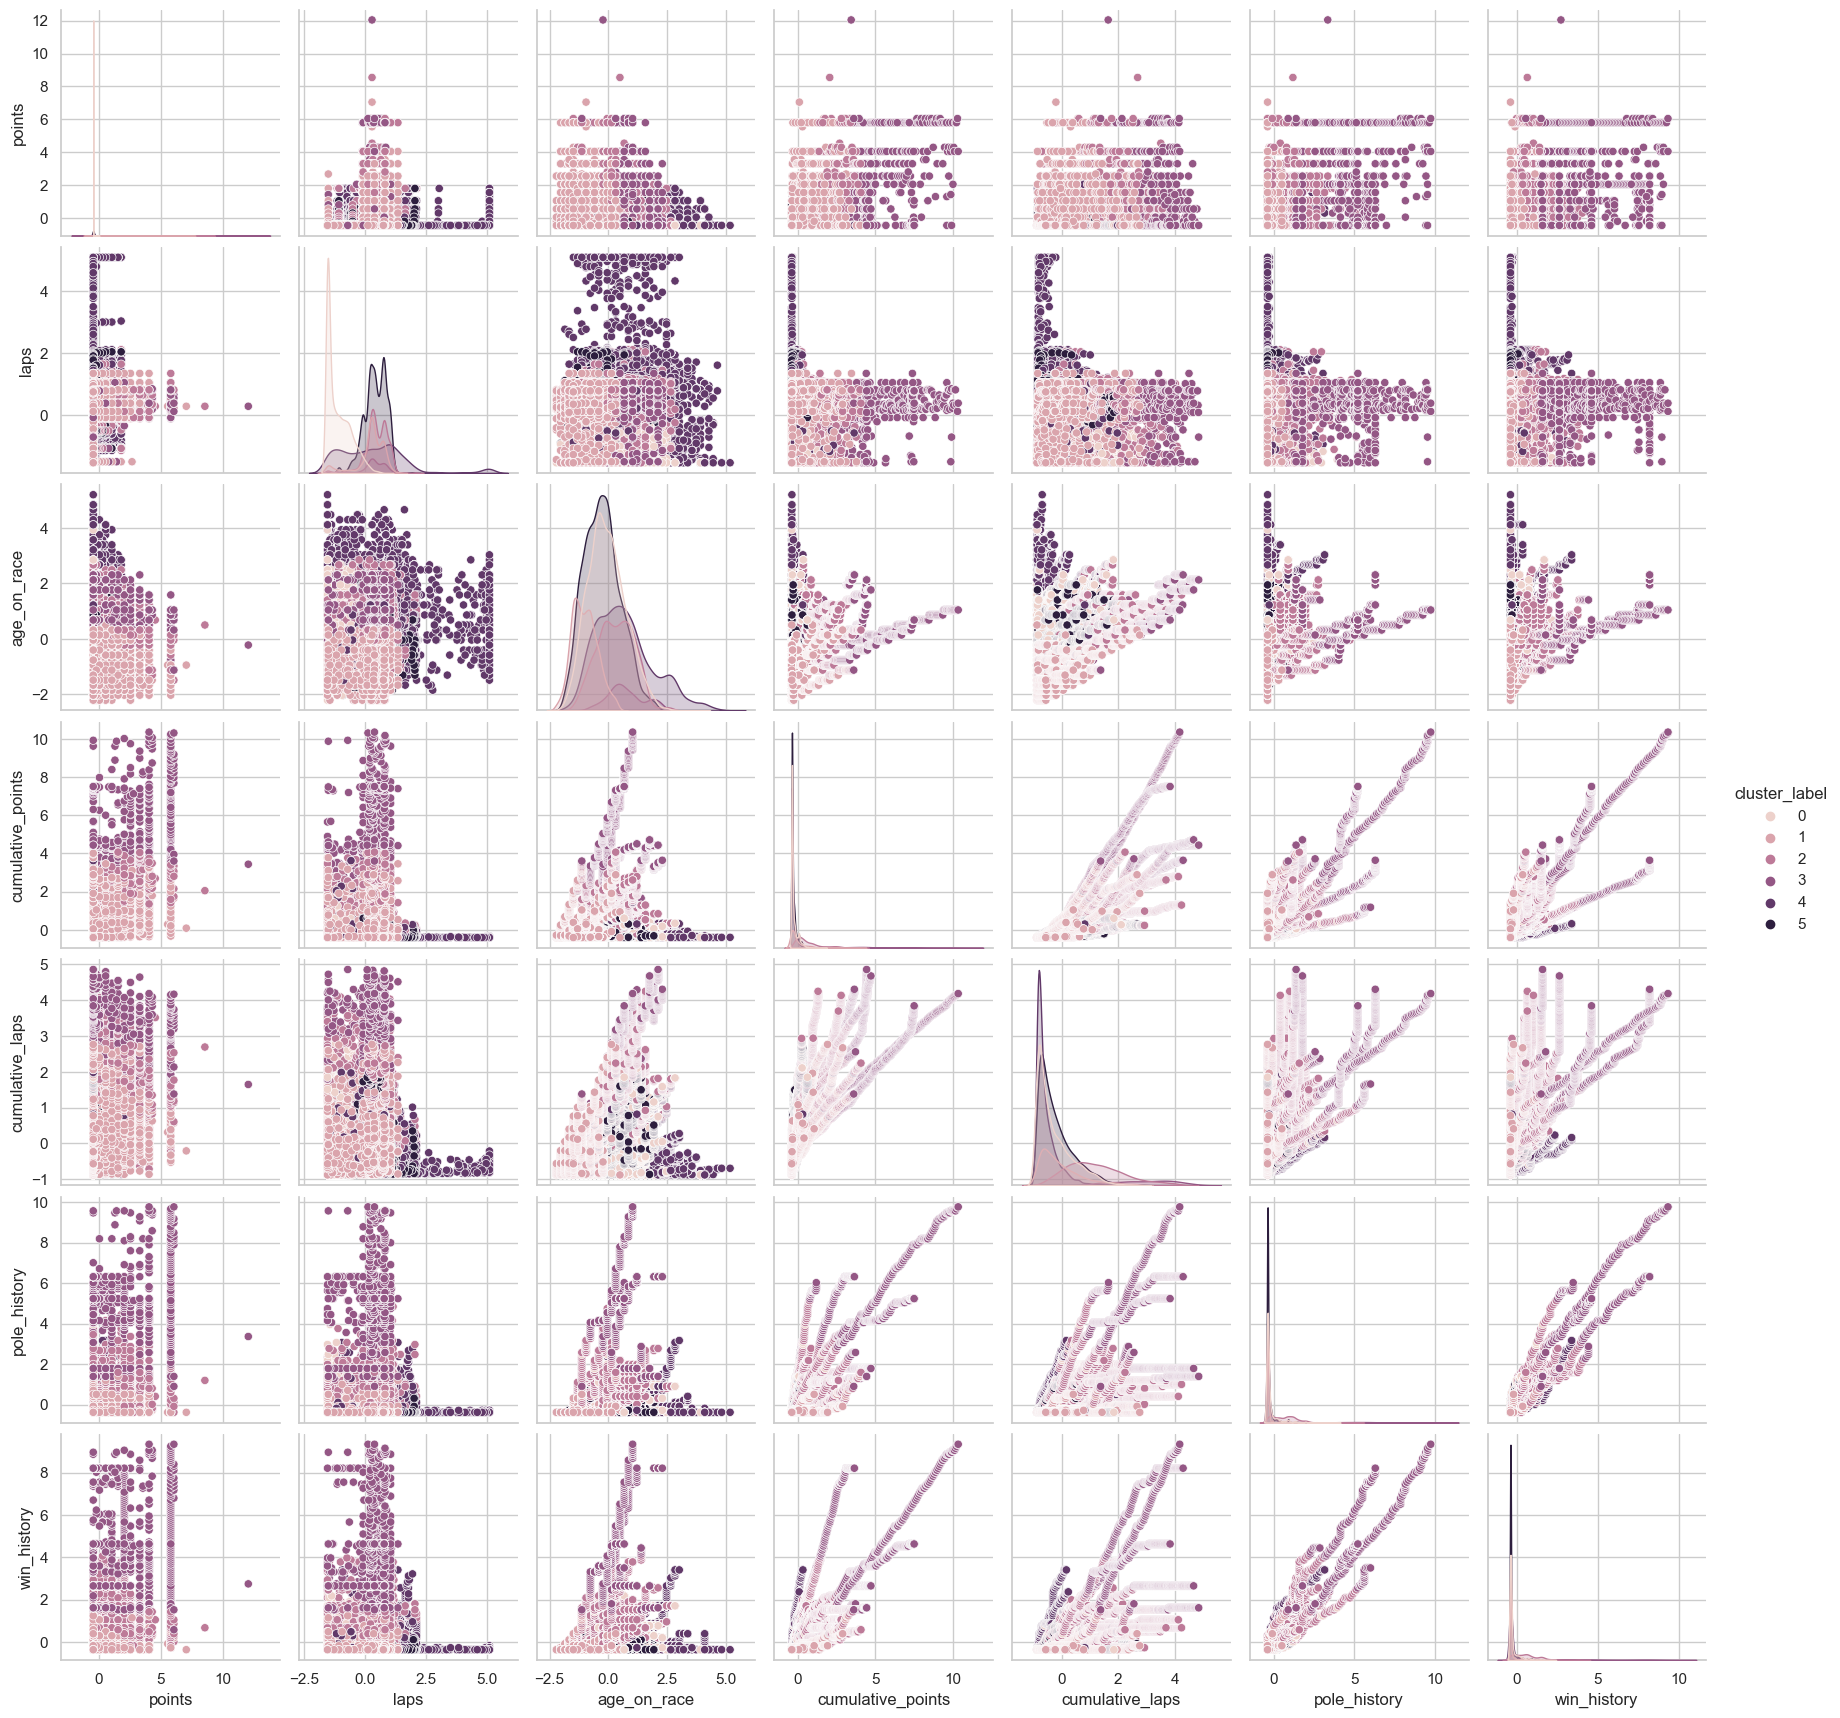

In [179]:
# plot the clusters

features = ['season', 'driverId' , 'round' , 'circuitId' , 'pole_driverId' , 'position' ,'points', 'grid',
                    'laps', 'age_on_race', 'cumulative_points', 'cumulative_laps', 'pole_history', 'win_history', 'win_driverId', 'cluster_label']

sns.pairplot(df[features], hue='cluster_label')

## Hyper-parameter Tuning

- `Hyper-parameters` are variables that you specify while building a machine-learning model. This means that it’s the user that defines the hyper-parameters while building the model. Hyper-parameters control the learning process, while parameters are learned.
- The performance of a model significantly depends on the value of hyperparameters. Note that there is no way to know in advance the best values for hyperparameters so ideally, we need to try all possible values to know the optimal values. 
- Doing this manually could take a considerable amount of time and resources.
- Hence we create functions with loops and parameters and try to find the best possible Hyper-parameter(s) based on a metric. This metric changes between algorithm to algorithm and also betwwen methods inside the algorithm. For example, in clustering silhouette method is a very commonly used method to determine hyper-parameters and it is based on maximizing the silhouette score, but there are other methods too to determine hyper-parameters such as Elbow method, Grubbs and so on.
- Elbow Method is good for finding optimal hyper-parameters when the dimension of the dataset is low but for high dimension data, Silhouette method is preferred.

### Silhouette Method

- Similar to Elbow Method, `Silhouette method` is also a method to find the optimal number of clusters or other hyper-parameters and also to validate the consistency of data inside the clusters.
- This method calculates silhouette coefficients for each of point, and averages it out for all the samples to get the silhouette score. The set of hyper-parameters with maximum silhouette score is chosen.
- There are 2 main terms to be known to understand silhouette scores:
    - Cohesion (Similarity to its own cluster)
    - Separation (Similarity to other clusters)
- The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette scores lie between the range [-1,1] where a value close to the upper limit shows that a point is well matched to the cluster and a value close to the lower limit shows that it isn't. After calculating silhouette values of all the points in the data, the silhouette score can be determined by averaging out the silhouette values.
- The silhouette coefficient, s(i), can be calculated by the following formula:<br> _where: <br> a(i): The average distance of that point with all other points in the same clusters and <br>b(i): The average distance of that point with all the points in the closest cluster to its cluster;_
$$ s_{i} = \frac {b_{i} - a_{i}}{max(b_{i}, a_{i})} $$

### Hyper-Parameter tuning function (maximize_silhouette)

- There are tons of different models that can be used to perform Clustering but for this dataset, we are focusing mainly on the 4 most used methods which are:
    - `K-Means`
    - `DBSCAN`
    - `Agglomerative`
    - `Birch`
- The tuning function takes in the dataset (X), algorithm to be used (algo), maximum number of loops to run (nmax) and a boolean function to plot the silhouette scores against hyper-parameter (i_plot). It converts our dataset into a contiguous array and runs models with different value of hyper-parameters using a for loop and computes silhouette scores for each iteration. It then stores the optimal values of hyper-parameter, label and model and returns it out. If the i_plot parameter is set to 'True', the function will also a plot a graph of silhouette score v/s hyper-parameter.

In [197]:
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    
    if algo in ["kmeans","birch","ag"]:
        
        for param in range(3,nmax+1):
            
            if(algo=="birch"):
                
                model = Birch(n_clusters=param).fit(X)
                labels=model.predict(X)

            if(algo=="ag"):
                
                model = AgglomerativeClustering(n_clusters=param).fit(X)
                labels=model.labels_

            if(algo=="kmeans"):
                
                model = KMeans(n_clusters=param, init='k-means++').fit(X)
                labels=model.predict(X)

            try:
                
                sil_scores.append(silhouette_score(X,labels))
                params.append(param)
                
            except:
                
                continue 

            if(i_print): print(param,sil_scores[-1])
            
            if(sil_scores[-1]>sil_max):
                opt_param=param
                sil_max=sil_scores[-1]
                opt_labels=labels
                opt_model=model
                
    elif algo in ["dbscan"]:
        
        for eps in np.arange(0.2, nmax+1, 0.2):
                
                model = DBSCAN(eps=eps, min_samples=X.shape[1]*2).fit(X)
                labels=model.labels_
                
                try:
                        
                    sil_scores.append(silhouette_score(X,labels))
                    params.append(eps)
                    
                except:
                            
                    continue
            
                if(i_print): print(eps,sil_scores[-1])
            
                if(sil_scores[-1]>sil_max):
                    opt_param=eps
                    sil_max=sil_scores[-1]
                    opt_labels=labels
                    opt_model=model
   
    #print("Optimal Parameter for {} algorithm = {}".format(algo,opt_param))

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels, opt_param, opt_model

#### K-Means Algorithm (Hyper-Parameter = n_clusters)

- `K-Means Algorithm` is a type of Partition-based or Centroid-based clustering.
- `How does the K-Means algorithm work?`
    - First we choose k random data points and assign those as centroids or cluster centres.
    - Then for every data point, we see which centroid is nearest to it using some measurement method such as Euclidean (default) or Manhattan.
    - We assign the data point to that centroid.
    - The new centroi is now at the average distance of the centroid chosen before and the data point assigned to it.
    - Repeat the previous 3 steps until the centroid stops changing.
    - The algorithm is said to have “converged” once there are no more changes.
- The goal is to minimize the sum of the distances between the data points and the cluster centroid in order to determine which group each data point should belong to.
- K-means follows the same approach as Expectation-Maximization(EM). EM is an iterative method to find the maximum likelihood of parameters where the machine learning model depends on unobserved features. This approach consists of two steps Expectation(E) and Maximization(M) and iterates between these two.
- `Advantages`:
    - Relatively easy to understand and implement.
    - Scalable to large datasets.
    - Better computation cost.
    - Easily warm start the assignments and positions of centroids.
- `Disadvantages`:
    - Choosing K manually and being dependent on the initial values.
    - Lacks consistent results for different values of K.
    - Always tries to find circular clusters.
    - Centroids get dragged due to outliers in the dataset.
    - Curse of dimensionality, K is ineffective when the number of dimensions increases.
- For this exercise, we are choosing the hyper-parameter to tune as n_clusters while the other hyper-parameters are set to default. The tuning function calculates the maximum silhouette score for n_cluster values from 1-10 and outputs the Silhouette v/s N-Clusters graph. The labels are then predicted and appended to our original dataset for plotting clusters using Seaborn's Pairplot function.

KMeans Algorithm


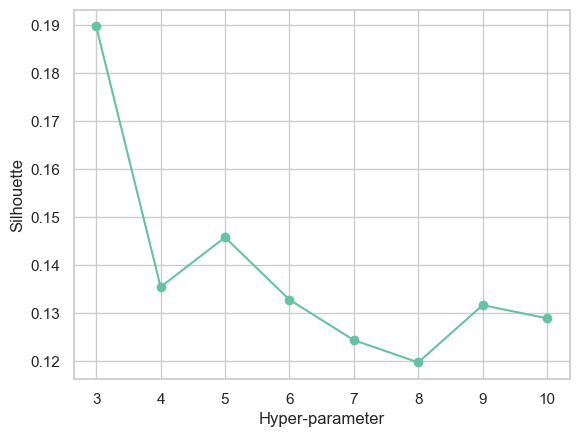

The number of clusters for Kmeans algorithm is:  3
Cluster Plots for Kmeans algorithm


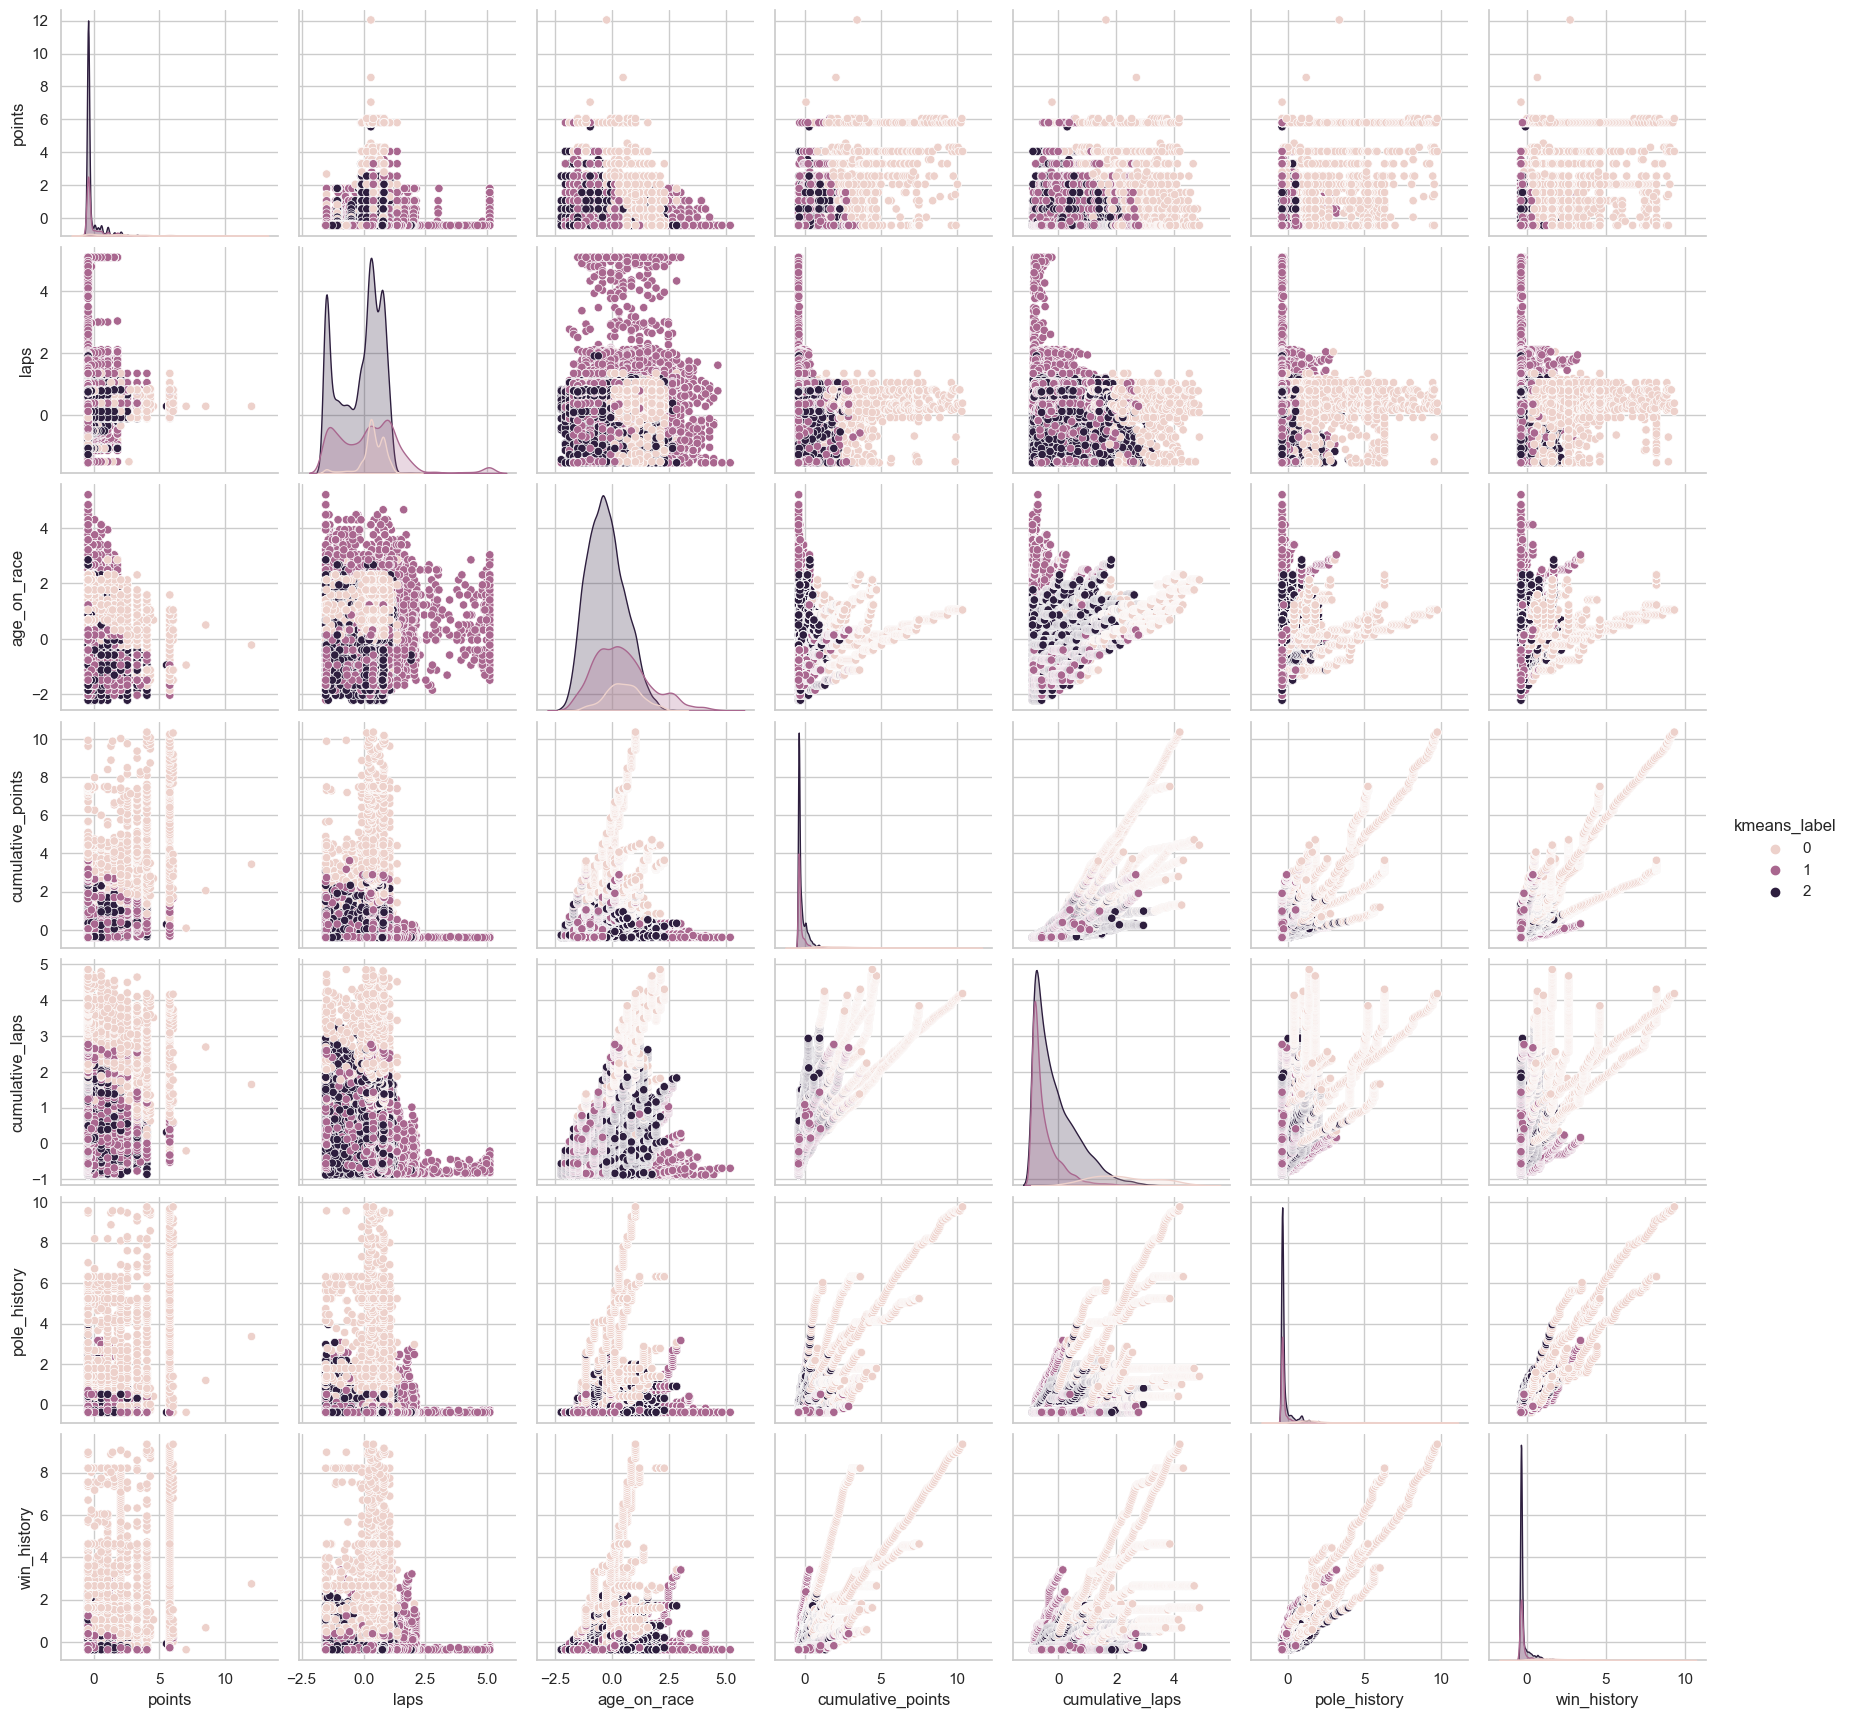

Time taken for KMEANS algorithm: 2.348343348503113 minutes


In [205]:
algo_features = ['season', 'driverId' , 'round' , 'circuitId' , 'pole_driverId' , 'position' ,'points', 'grid',
                    'laps', 'age_on_race', 'cumulative_points', 'cumulative_laps', 'pole_history', 'win_history', 'win_driverId']

start = time.time()
print('KMeans Algorithm')

kmeans_labels, n_clusters, kmeans_model = maximize_silhouette(X, 'kmeans', 10, True)
print('The number of clusters for Kmeans algorithm is: ', len(np.unique(kmeans_labels)))
df['kmeans_label'] = kmeans_labels
algo_features.append('kmeans_label')
print('Cluster Plots for Kmeans algorithm')
sns.pairplot(df[algo_features], hue='kmeans_label')
plt.show()
end = time.time()
print('Time taken for KMEANS algorithm: {} minutes'.format((end - start)/60))

In [207]:
df['kmeans_label'].value_counts()

2    17146
1     7349
0     2126
Name: kmeans_label, dtype: int64

In [208]:
df['label'].value_counts()

Outside_Top_10    15364
Top_10             7866
Podium             3391
Name: label, dtype: int64

In [231]:
df['kmeans_accuracy'] = 0
for i in range(len(df)):
    
    if df['kmeans_label'][i] == 0 and df['label'][i] == 'Podium':
        df['kmeans_accuracy'][i] = 1
    
    elif df['kmeans_label'][i] == 1 and df['label'][i] == 'Top_10':
        df['kmeans_accuracy'][i] = 1
        
    elif df['kmeans_label'][i] == 2 and df['label'][i] == 'Outside_Top_10':
        df['kmeans_accuracy'][i] = 1
        
    else:
        df['kmeans_accuracy'][i] = 0

print('The accuracy of correct clusters formed by K-Means Algorithm = {} %'.format(df['kmeans_accuracy'].mean()*100))

The accuracy of correct clusters formed by K-Means Algorithm = 55.47500093910822 %


##### Results for K-Means Algorithm
- `The optimal number of clusters formed came out to be 3` which is also equal to the number of labels present in the original dataset. 
- But after comparing proposed cluster labels with the original labels, around `14,800 out of 26,000 values (55.475%) are matching with each other`. This is due to the fact that our dataset is historical and contains a lot of inter-dependencies between the features which leads the algorithm to not create clusters properly as it is a simple clustering algorithm. Another reason might be that the dimensionality of the data is very high and this makes it very complex.

#### DBSCAN Algorithm (Hyper-Parameter = eps)

- DBSCAN stands for _Density-Based Spatial Clustering of Applications with Noise_ and it is a Density Based Algorithm.
- It works on the assumption that clusters are dense regions in space separated by regions of lower density. Densely grouped data points are grouped into a single cluster.
- By seeing local density of data points in large spatial datasets, the clusters are identified.
- This algorithm is robust to outliers and the number of clusters to make cannot be specified as a hyper-parameter.
- Let a given dataset of points (dataset D = {xi}), we have to partition the point into the dense region which we will call them as Clusters and sparse region which may contain noise.
- The 2 main hyper-parameters for this model are:
    - `Epsilon (eps)`: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered to be neighbors.
    - `Minimum number of Points (min_samples)`: the minimum number of points to form a dense region. For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.
- There are 3 types of points in this algorithm:
    - `Core Point`: The point where, within the specified 'eps' radius it has more than the specified min_samples number of points. This points always belongs to a dense region.
    - `Border Point`: A point where, within the specified 'eps' radius it has less than the specified min_samples number of points but it is in the neighborhood of a core point.
    - `Noise Point`: A point that does not belong to both a Core point or a Border Point.
- Every point in the dataset on given min_samples and eps, can categorize every data point into Core point, Border point and Noise point.
- `Density Edge`: If p and q both are core points and distance between (p,q) ≤ eps then we can connect p, q vertex in a graph and call it “Density Edge”.
- `Density Connected Points`: Two points p and q are said to be density connected points if both p and q are core points and they exist a path formed by density edges connecting point (p) to point(q).
- `How does the DBSCAN algorithm work?`
    - Label the points as Core, Border and Noise Point.
    - Get rid of every Noise point as they do not belong to any density region (cluster).
    - For every core point that has not been assigned to any cluster yet:
        - create a new cluster with the point p and
        - add all the points that are density-connected to p.
    - Assign each border points to the cluster of the closest core point.
- `Advantages`:
    - It can handle Noise very well.
    - DBSCAN can handle clusters of different shapes and sizes.
- `Disadvantages`:
    - If your dataset has multiple densities or varying densities, DBSCAN tends to fail. It does not work very well in such cases.
    - It’s extremely sensitive to the hyperparameters. A slight change in hyperparameters can lead to a drastic change in the outcome.
    - As we know, a concept like Density, may not work well in high dimensionality of data. We should avoid using it for text data.
- For this exercise, we are choosing the hyper-parameter to tune as eps while min_samples is taken as twice the dimensionality of the data (33*2 = 66) and other hyper-parameters are set to default. 
    - The range of values where eps will lie between is calculated using K-distance graph while calculates K-nearest neighbors (n_neighbors = dimensionality of data multiplied by 2) and their distances.
    - The tuning function calculates the maximum silhouette score for eps values between (0.2, 0.4, 0.6, ... , 3) and outputs the Silhouette v/s Eps graph. The labels are then predicted and appended to our original dataset for plotting clusters using Seaborn's Pairplot function.


In [213]:
neighbors = NearestNeighbors(n_neighbors=66)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

Text(0.5, 1.0, 'K-Distance Graph for DBSCAN')

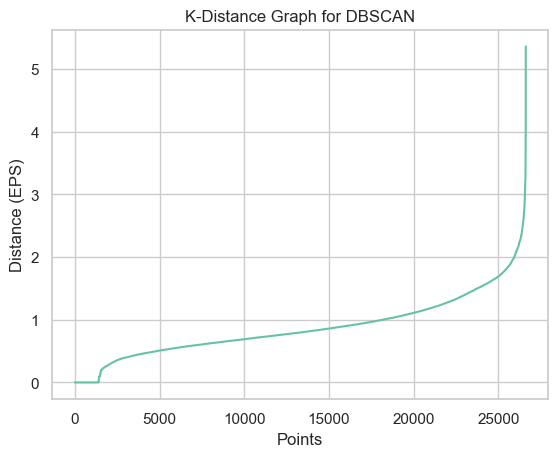

In [214]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance (EPS)')
plt.title('K-Distance Graph for DBSCAN')

DBSCAN Algorithm


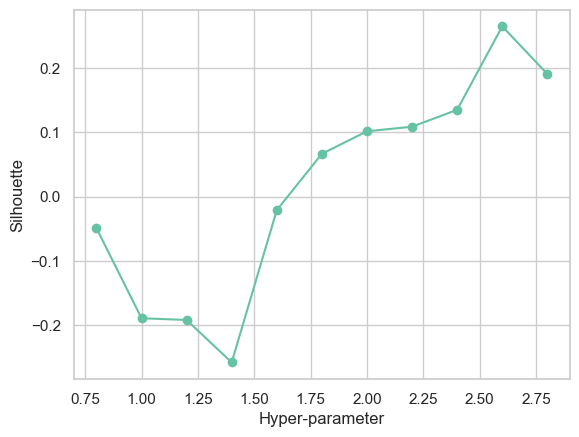

The EPS for DBSCAN algorithm is: 2.6000000000000005
The number of clusters for DBSCAN algorithm is:  3
Cluster Plots for DBSCAN algorithm


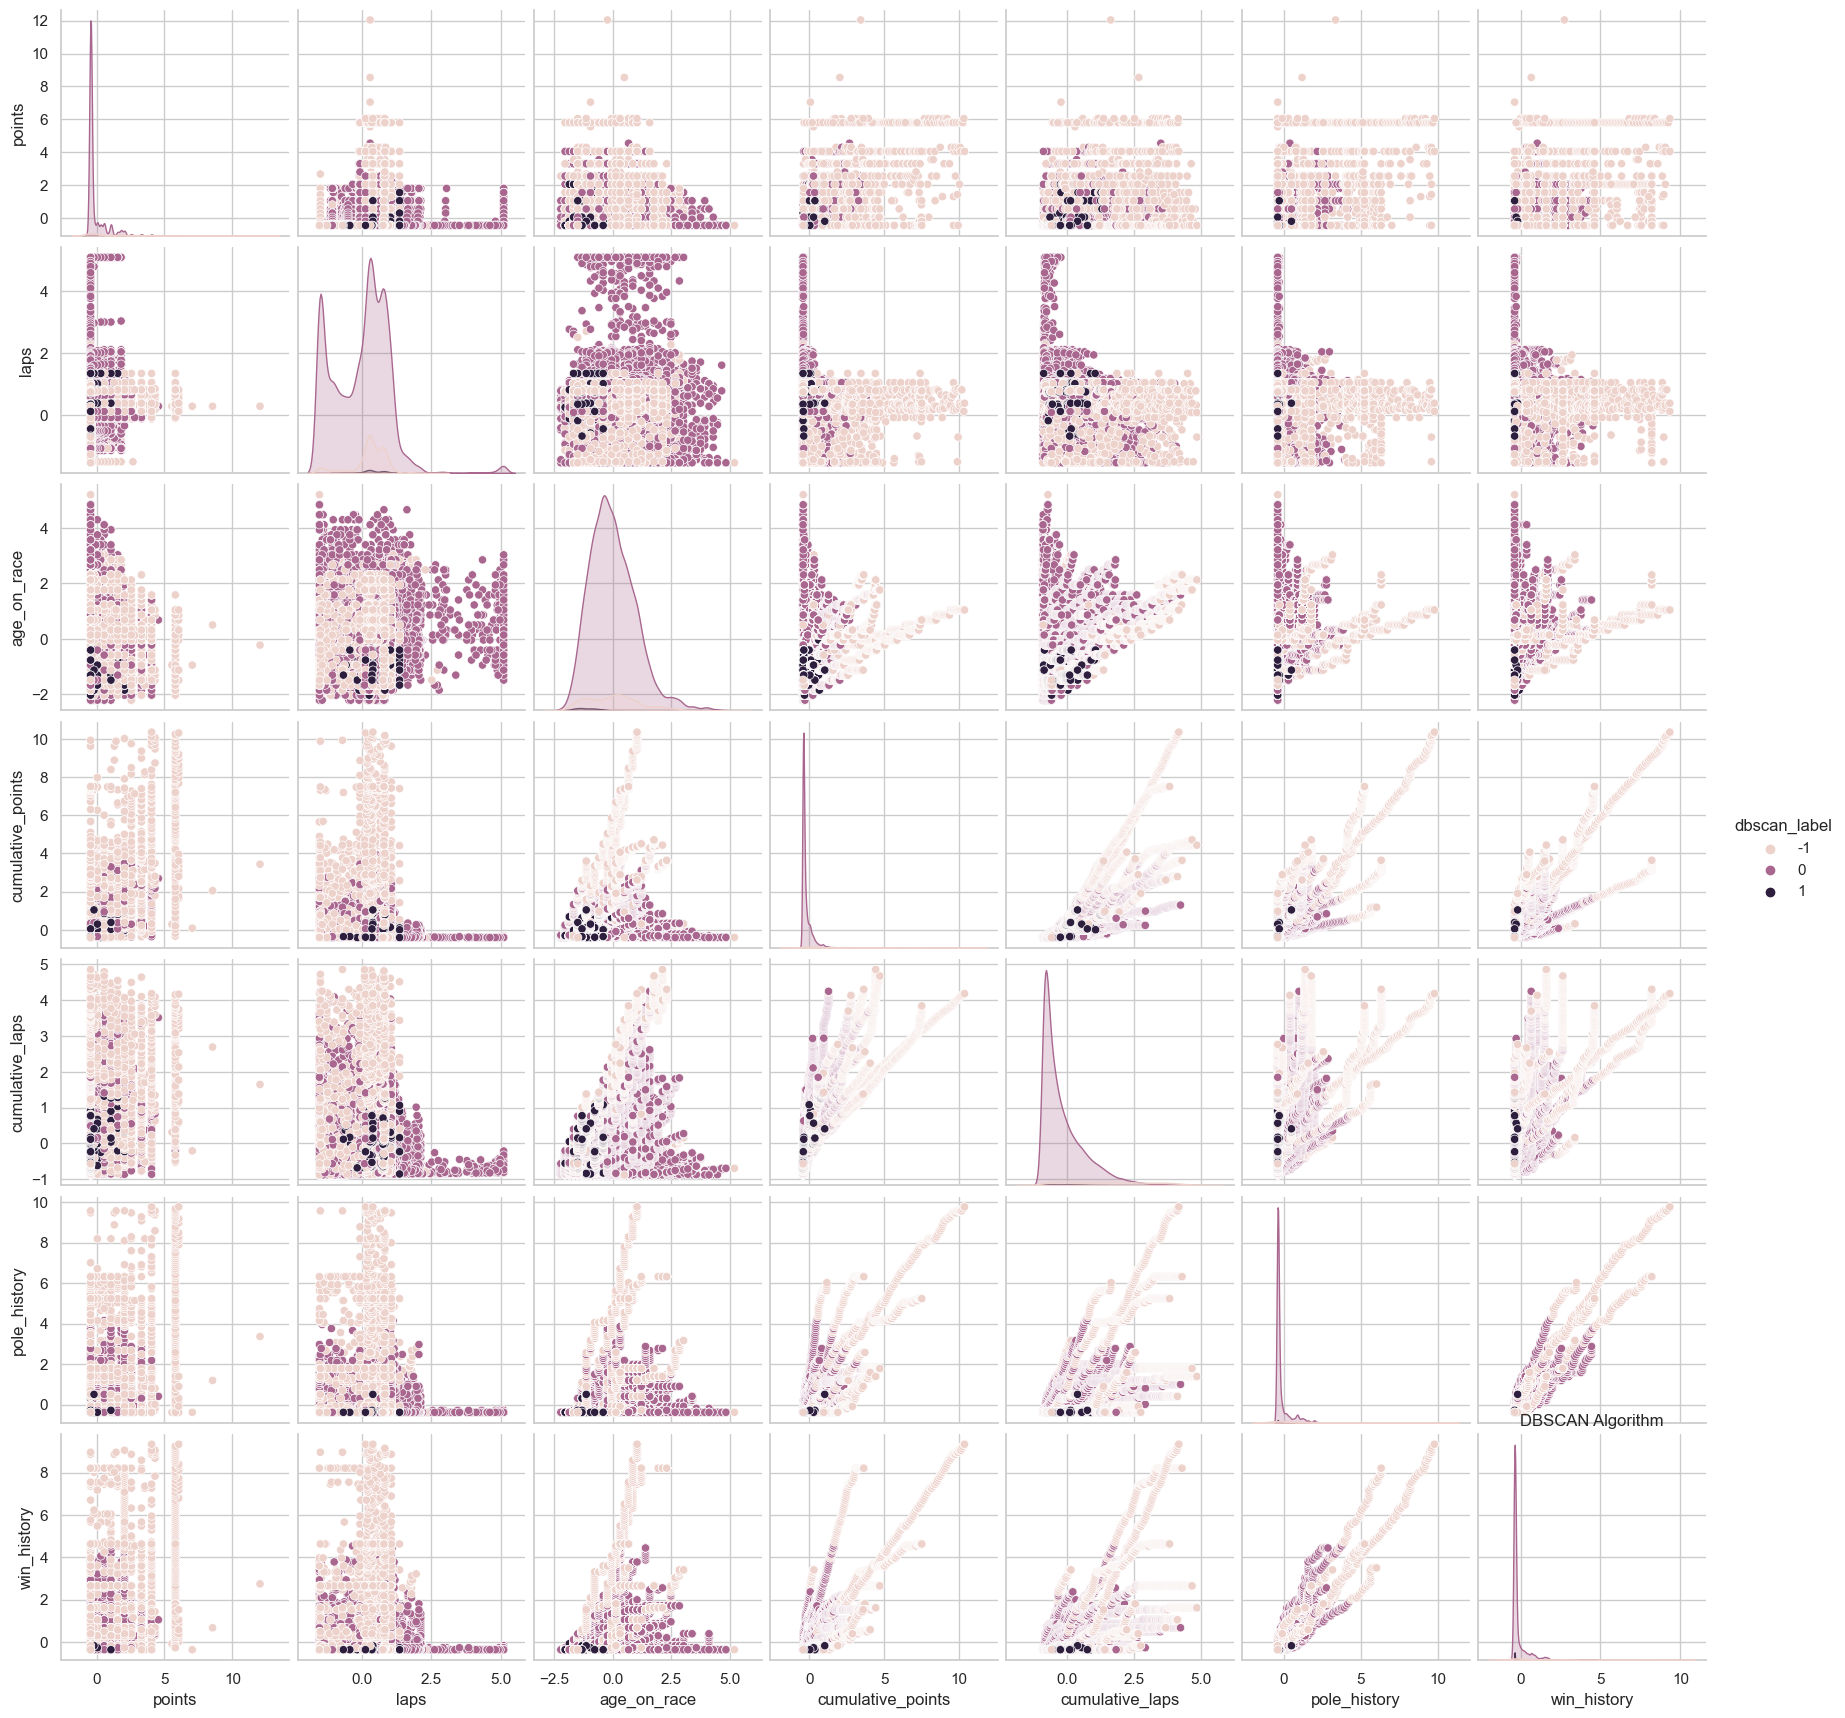

Time taken for DBSCAN algorithm: 3.2984065810839334 minutes


In [217]:
algo_features = ['season', 'driverId' , 'round' , 'circuitId' , 'pole_driverId' , 'position' ,'points', 'grid',
                    'laps', 'age_on_race', 'cumulative_points', 'cumulative_laps', 'pole_history', 'win_history', 'win_driverId']

start = time.time()
print('DBSCAN Algorithm')

dbscan_labels, parameter, db_model = maximize_silhouette(X, 'dbscan', 2, True)
print('The EPS for DBSCAN algorithm is: {}'.format(parameter))
print('The number of clusters for DBSCAN algorithm is: ', len(np.unique(dbscan_labels)))
df['dbscan_label'] = dbscan_labels
algo_features.append('dbscan_label')
print('Cluster Plots for DBSCAN algorithm')
sns.pairplot(df[algo_features], hue='dbscan_label')
plt.title('DBSCAN Algorithm')
plt.show()
end = time.time()
print('Time taken for DBSCAN algorithm: {} minutes'.format((end - start)/60))

In [218]:
df['dbscan_label'].value_counts()

 0    24342
-1     2130
 1      149
Name: dbscan_label, dtype: int64

In [219]:
df['label'].value_counts()

Outside_Top_10    15364
Top_10             7866
Podium             3391
Name: label, dtype: int64

In [229]:
df['dbscan_accuracy'] = 0
for i in range(len(df)):
    
    if df['dbscan_label'][i] == 0 and df['label'][i] == 'Outside_Top_10':
        df['dbscan_accuracy'][i] = 1
    
    elif df['dbscan_label'][i] == -1 and df['label'][i] == 'Top_10':
        df['dbscan_accuracy'][i] = 1
        
    elif df['dbscan_label'][i] == 2 and df['label'][i] == 'Podium':
        df['dbscan_accuracy'][i] = 1
        
    else:
        df['dbscan_accuracy'][i] = 0
        
print('The accuracy of correct clusters formed by DBSCAN Algorithm = {} %'.format(df['dbscan_accuracy'].mean()*100))

The accuracy of correct clusters formed by DBSCAN Algorithm = 56.549340746027575 %


##### Results for DBSCAN Algorithm
- From the K-Distance graph it can be seen that the curve changes between the range 1-3 of eps and hence the `optimal value of epsilon should lie between 1 and 3`. 
- The tuning algorithm output shows that `the optimal eps value for which the silhouette score is maximum is 2.6`. 
- After putting our `hyper-parameters eps=2.6 and min_samples=66 the clusters formed came out to be 3` which is also equal to the number of labels present in the original dataset. 
- But after comparing proposed cluster labels with the original labels, around `15,050 out of 26,000 values (56.543%) are matching with each other`. This is due to the fact that our dataset is historical and contains a lot of inter-dependencies between the features which leads the algorithm to not create clusters properly as it is a simple clustering algorithm. Another reason might be that the dimensionality of the data is very high and this makes it very complex.

#### Agglomerative (Hierarchical) Algorithm (Hyper-Parameter = n_clusters)

- `Agglomerative Model` is a type of Hierarchical Clustering.
- It is also known as bottom-up clustering.
- The Agglomerative model works as follows: each object is initially considered as a single-element cluster (leaf). At each step of the algorithm, the two clusters that are the most similar are combined into a new bigger cluster (nodes). This procedure is iterated until all points are member of just one single big cluster (root).
- Pairs of clusters are merged as one moves up the hierarchy.
- The clusters are merged by finding the distance between 2 data points. The most famous method is the Euclidean distance.
- `Euclidean distance` is a method of finding distance between 2 points where distance is calculated by drawing a straight line between the 2 data points and then calculating the length of the line. The formula to calculate the distance between 2 points p and q is:
$$ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } $$
- `How does Agglomerative Clustering work?`
    - It starts by treating each observation as a separate cluster.
    - Distance Measurement: The distance is calculated between each observation using methods like Euclidean, Manhattan and so on. For example, suppose we have 3 features of 5 rows each. The distance between the Obs. 1 and Obs. 2 can be calculated using the formula above, and same for Obs. 1 and Obs. 3 and Obs. 2 and Obs. 4 and so on. After that, we merge the smallest non-zero distance in the matrix to create our first node. To calculate the distance between this newly created node to other data points, linkage criterion should be set.
    - Linkage Criterion: The linkage criterion is where exactly the distance is measured. The simplest linkage criterion is _Single Linkage_. In a single linkage criterion, we define our distance as the minimum distance between clusters data point. In other words, let's assume that in our previous example, The node came to be as (Obs. 1, Obs. 3). Now to calculate distance between this node and Obs. 2, we will calculate individual distances (using Euclidean distance formula) between the node and Obs. 2 i.e., Distance between Obs. 1 and Obs. 2 and Obs. 3 and Obs. 2. The minimum of these 2 distances will be taken as the distance between the node (Obs. 1, Obs. 3) and Obs. 2. The same goes for Obs. 4 and Obs. 5 as well.
    - The next step would be again look at distances and merge points with the minimum distance. Continuing the same example, now suppose Obs. 2 and Obs. 4 have the least distance, hence it is merged into a node. Now we are left with 2 nodes: (Obs. 1, Obs. 3) and (Obs. 2, Obs. 4) and 1 other data point: Obs. 5. Again the distances are calculated using the linkage criterion and the nodes are merged again.
    - We keep the merging ongoing until all the data is clustered into one cluster. In the end, we would obtain a dendrogram with all the data that have been merged into one cluster.
- `Advantages`:
    - No need for information about how many numbers of clusters are required.
    - Easy to use and implement
- `Disadvantages`:
    - We can not take a step back in this algorithm.
    - Time complexity is higher at least O(n^2logn)
- For this exercise, we are choosing the hyper-parameter to tune as n_clusters while the other hyper-parameters are set to default. The tuning function calculates the maximum silhouette score for n_cluster values from 1-10 and outputs the Silhouette v/s N-Clusters graph. The labels are then predicted and appended to our original dataset for plotting clusters using Seaborn's Pairplot function.



Agglomerative (Hierarchical) Algorithm


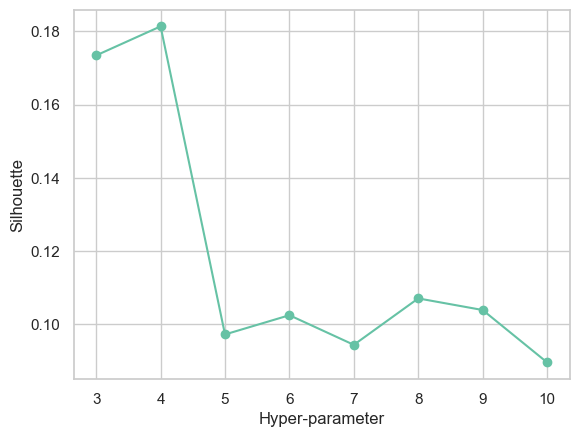

The number of clusters for Agglomerative (Hierarchical) algorithm is:  4
Cluster Plots for Agglomerative (Hierarchical) algorithm


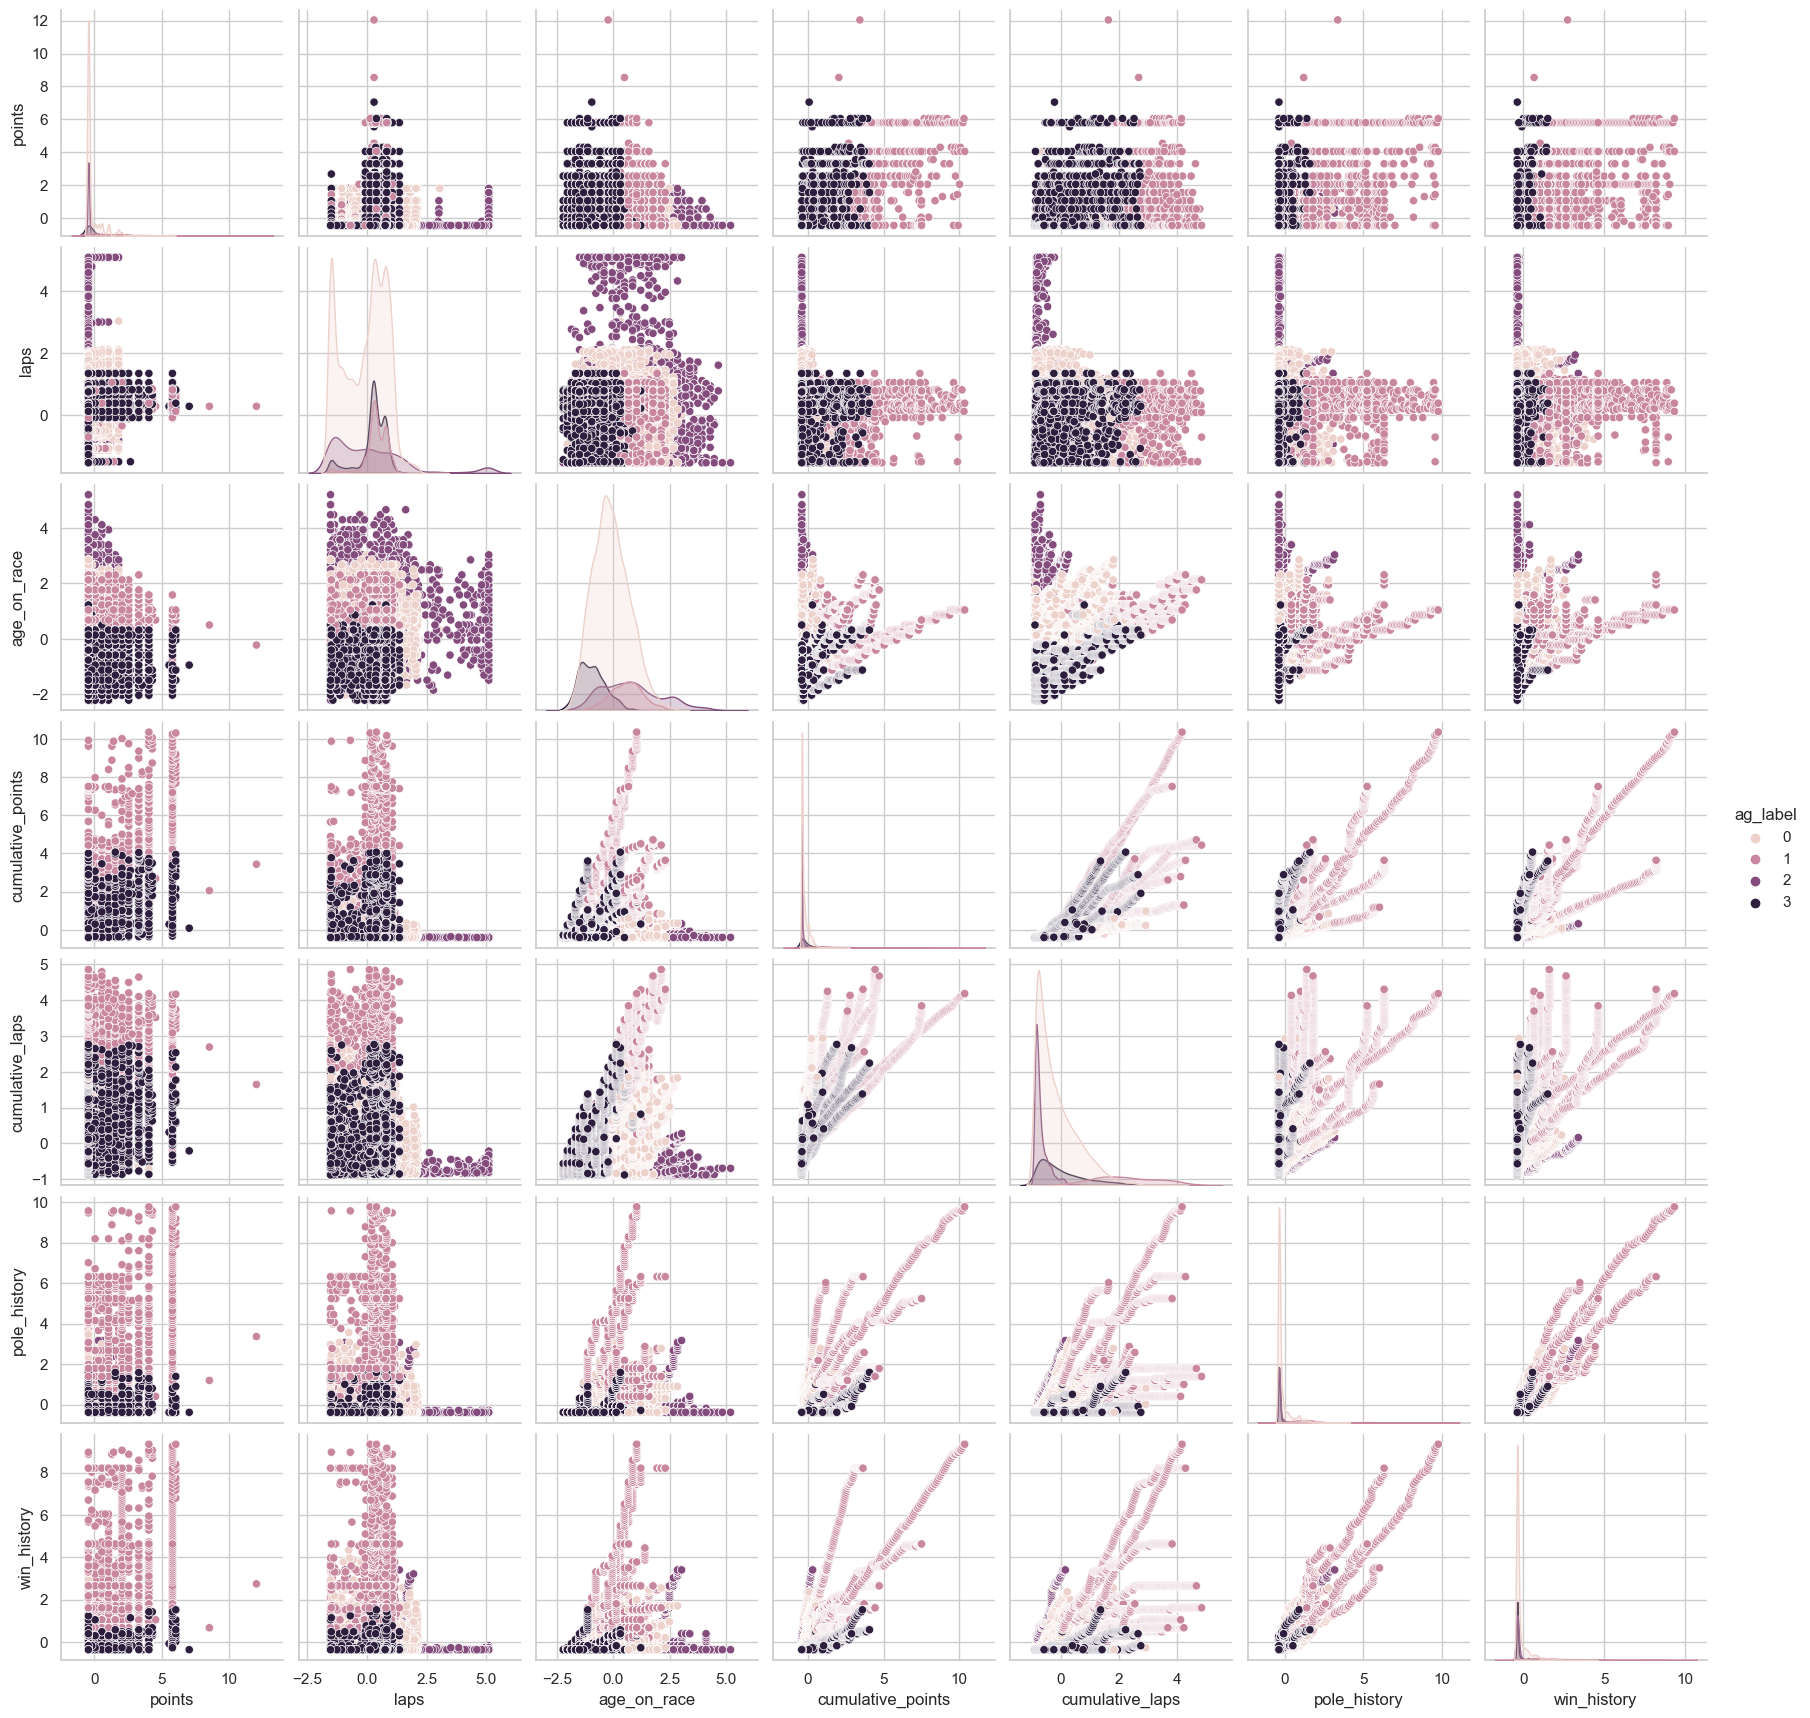

Time taken for Agglomerative (Hierarchical) algorithm: 5.082929484049479 minutes


In [222]:
algo_features = ['season', 'driverId' , 'round' , 'circuitId' , 'pole_driverId' , 'position' ,'points', 'grid',
                    'laps', 'age_on_race', 'cumulative_points', 'cumulative_laps', 'pole_history', 'win_history', 'win_driverId']

start = time.time()
print('Agglomerative (Hierarchical) Algorithm')

ag_labels, n_clusters, agg_model = maximize_silhouette(X, 'ag', 10, True)
print('The number of clusters for Agglomerative (Hierarchical) algorithm is: ', len(np.unique(ag_labels)))
df['ag_label'] = ag_labels
algo_features.append('ag_label')
print('Cluster Plots for Agglomerative (Hierarchical) algorithm')
sns.pairplot(df[algo_features], hue='ag_label')
plt.show()
end = time.time()
print('Time taken for Agglomerative (Hierarchical) algorithm: {} minutes'.format((end - start)/60))

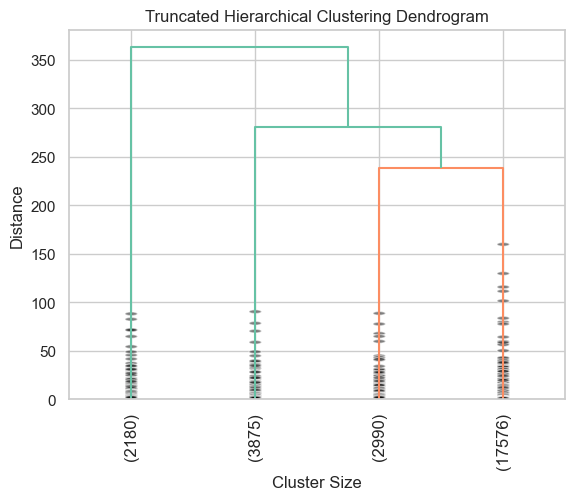

In [233]:
X1 = df.drop(['label', 'ag_label', 'dbscan_label', 'kmeans_label', 'cluster_label', 'kmeans_accuracy', 'dbscan_accuracy'], axis=1)

Z = linkage(X1, method='ward')
dend = dendrogram(Z, truncate_mode='lastp',  # show only the last p merged clusters
    p=4,
    leaf_rotation=90,
    leaf_font_size=12,
    show_contracted=True)
plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [223]:
df['ag_label'].value_counts()

0    17576
2     3875
3     2990
1     2180
Name: ag_label, dtype: int64

In [224]:
df['label'].value_counts()

Outside_Top_10    15364
Top_10             7866
Podium             3391
Name: label, dtype: int64

In [228]:
df['ag_accuracy'] = 0
for i in range(len(df)):
    
    if df['ag_label'][i] == 0 and df['label'][i] == 'Outside_Top_10':
        df['ag_accuracy'][i] = 1
    
    elif df['ag_label'][i] == 2 and df['label'][i] == 'Top_10':
        df['ag_accuracy'][i] = 1
        
    elif df['ag_label'][i] == 3 and df['label'][i] == 'Top_10':
        df['ag_accuracy'][i] = 1
        
    elif df['ag_label'][i] == 1 and df['label'][i] == 'Podium':
        df['ag_accuracy'][i] = 1
        
    else:
        df['ag_accuracy'][i] = 0
        
print('The accuracy of correct clusters formed by Agglomerative (Hierarchical) Algorithm = {} %'.format(df['ag_accuracy'].mean()*100))

The accuracy of correct clusters formed by Agglomerative (Hierarchical) Algorithm = 51.185154577213474 %


##### Results for Agglomerative (Hierarchical) Algorithm
- `The optimal number of clusters formed came out to be 4` which is not equal to the number of labels present in the original dataset. 
- It is also seen that if we merge clusters 2 and 3 and then compare the proposed cluster labels with the original labels, around `13,600 out of 26,000 values (51.185%) are matching with each other` which is the highest among all the other merges of clusters ([1,3], [2,4], [1,4] and so on).
-  This means that maybe we should consider splitting the Top_10 label into 2 and then run other models. 
- But since the matching score is not high, we will not implement it.

# Final Results
- Comparing the time taken for running each of the Clustering Algorithms, it is noticed that Agglomerative (Hierarchical) Algorithm takes the most time (5.08 minutes) followed by DBSCAN algorithm (3.29 minutes) and K-means Algorithm is the fastest among all (2.34 minutes).
- The Clusters formed for K-Means and DBSCAN (3) match the original number of labels (3) but the matching score for DBSCAN is higher than that of K-means (by 1%).
- The Clusters formed for Agglomerative (4) do not match the original number of labels (3) which gives us a new insight into the data and the target variable.
- The complexity of DBSCAN is greater as compared to the other 2 algorithms even after simplifying the algorithm by taking an important hyper-parameter (min_samples) as constant (dimensionality*2 = 66).
- From the cluster plots of each algorithm, it is seen that clusters are more distinct for Agglomerative followed by K-means and finally DBSCAN. 

# Conclusion
- Even though the matching score is a little higher for DBSCAN Algorithm, I would still choose K-means Algorithm as our optimal algorithm to perform clustering because of the fast processing time and less complexity.
- The Agglomerative Algorithm shows us that maybe the label variables should be split into 4, or specifically the 'Top_10' variable should be split into 2 to give better clusters.
- From the dataset we can get basic idea that the Top_10 label can be split into 2 with positions 4 to 6 as one and positions 7 to 10 as the other.
- But since the matching score of Agglomerative is not higher than the other 2 algorithms, the Top_10 variable should not be split and the labels we have taken are correct. 
- The complexity, size of the data and the fact that the data is historical so there many features have inter-dependencies accounts for low matching scores across all Clustering algorithms.